# 모델들을 한 파일에 담아서 봅시다

### 모델 순서 
1. 로지스틱
2. 의사결정트리
3. 랜덤포레스트
4. 그라이언트 부스팅
5. XGBoost

*다른 것들은 생략하고 일단 모델들과 점수만 봅시다.*

In [1]:
#데이터 용 pandas
import pandas as pd
import numpy as np
#데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
#모델 split, 하이퍼 파라미터 서치 , 점수 확인과 교차검증
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
#의사결정 트리
from sklearn.tree import DecisionTreeClassifier
#랜덤포레스트
from sklearn.ensemble import RandomForestClassifier
#그레디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier
#XGboost
import xgboost as xgb
#모델
from sklearn.preprocessing import StandardScaler, LabelEncoder
#로지스틱회귀
from sklearn.linear_model import LogisticRegression
#모델 점수 확인 정확도 평가지표 그림 재현율 f1스코어 roc커브 , 점수함수 적용용 모듈
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,recall_score, f1_score, roc_auc_score,make_scorer, roc_curve, auc


In [2]:
data = pd.read_csv("../data/Model_Preprocess.csv")

In [3]:
data.columns

Index(['Complains', 'Charge Amount', 'Distinct Called Numbers', 'Tariff Plan',
       'Status', 'Customer Value', 'Churn', 'Usage Index'],
      dtype='object')

In [4]:
data['Usage Index'].describe()

count    3.030000e+03
mean     8.911097e-17
std      2.289222e+00
min     -2.986032e+00
25%     -1.878309e+00
50%     -5.465197e-01
75%      1.579408e+00
max      5.888933e+00
Name: Usage Index, dtype: float64

In [6]:

# 그래프에서 한글이 깨지면 사용합니다.
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [7]:
# 타겟 변수와 피쳐 변수로 분할
X = data.drop(columns=['Churn'])
y = data['Churn']

### 1. 로지스틱

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}  
Accuracy: 0.91

In [8]:
#로지스틱회귀
target_column = 'Churn'

# 범주형 변수 인코딩
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    if column != target_column:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

# 타겟 변수 인코딩
label_encoders[target_column] = LabelEncoder()
data[target_column] = label_encoders[target_column].fit_transform(data[target_column])

# 특징 변수와 타겟 변수 분리
X = data.drop(columns=[target_column])
y = data[target_column]

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# 특징 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 로지스틱 회귀 모델 및 하이퍼파라미터 튜닝
param_grid_lg = {
    'C': [0.1, 1, 10, 100],  # 정규화 강도
    'penalty': ['l1', 'l2'],  # 페널티 유형
    'solver': ['liblinear']  # 최적화 알고리즘
}

grid_search_lg = GridSearchCV(LogisticRegression(random_state=4), param_grid_lg, cv=5, scoring='neg_log_loss')
grid_search_lg.fit(X_train, y_train)

# 최적의 모델 선택
best_lg_model = grid_search_lg.best_estimator_

# 모델 예측
y_pred = best_lg_model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Best Parameters: {grid_search_lg.best_params_}")
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.91
Confusion Matrix:
[[775   4]
 [ 77  53]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       779
           1       0.93      0.41      0.57       130

    accuracy                           0.91       909
   macro avg       0.92      0.70      0.76       909
weighted avg       0.91      0.91      0.90       909



### 2. 의사결정 트리 

Best Hyperparameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10}   
Accuracy: 0.911991199119912

In [9]:
# 타겟 변수와 피쳐 변수로 분할
X = data.drop(columns=['Churn'])
y = data['Churn']

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# 의사결정 트리 분류모델 초기화
dt_classifier = DecisionTreeClassifier(random_state=4)

# 하이퍼파라미터 그리드 설정
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search_dt = GridSearchCV(estimator=dt_classifier, param_grid=param_grid_dt, cv=5, scoring='neg_log_loss', n_jobs=-1, verbose=2)

# 모델 학습
grid_search_dt.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search_dt.best_params_

# 최적의 하이퍼파라미터로 모델 생성 및 학습
best_dt_classifier = DecisionTreeClassifier(**best_params, random_state=4)
best_dt_classifier.fit(X_train, y_train)

# 예측 수행
y_pred = best_dt_classifier.predict(X_test)

# 모델 평가
accuracy_dt = accuracy_score(y_test, y_pred)
report_dt = classification_report(y_test, y_pred)

print(f'Best Hyperparameters: {best_params}')
print(f'Accuracy: {accuracy_dt}')
print('Classification Report:')
print(report_dt)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.9152915291529153
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       779
           1       0.93      0.44      0.60       130

    accuracy                           0.92       909
   macro avg       0.92      0.72      0.77       909
weighted avg       0.92      0.92      0.90       909



### 3. 랜덤 포레스트

Best Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}  
Accuracy: 0.935093509350935

In [10]:

# 타겟 변수와 피쳐 변수로 분할
X = data.drop(columns=['Churn'])
y = data['Churn']


# # 랜덤 포레스트 분류기 초기화
rf_classifier = RandomForestClassifier(random_state=4)

# 하이퍼파라미터 그리드 설정
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# # GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=5, scoring='neg_log_loss', n_jobs=-1, verbose=2)

# 모델 학습
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search_rf.best_params_

# 최적의 하이퍼파라미터로 모델 생성 및 학습
best_rf_classifier = RandomForestClassifier(**best_params, random_state=4)
best_rf_classifier.fit(X_train, y_train)

# 예측 수행
y_pred = best_rf_classifier.predict(X_test)

# 모델 평가
accuracy_rf = accuracy_score(y_test, y_pred)
report_rf = classification_report(y_test, y_pred)

print(f'Best Hyperparameters: {best_params}')
print(f'Accuracy: {accuracy_rf}')
print('Classification Report:')
print(report_rf)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.9361936193619362
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       779
           1       0.82      0.72      0.76       130

    accuracy                           0.94       909
   macro avg       0.88      0.84      0.86       909
weighted avg       0.93      0.94      0.93       909



### 4. 그라이언트 부스팅

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}  
Accuracy: 0.9284928492849285

In [11]:
# 타겟 변수와 피쳐 변수로 분할
X = data.drop(columns=['Churn'])
y = data['Churn']

# 그라디언트 부스팅 분류기 초기화
gb_classifier = GradientBoostingClassifier(random_state=4)

# 하이퍼파라미터 그리드 설정
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search_gb = GridSearchCV(estimator=gb_classifier, param_grid=param_grid_gb, cv=5, scoring='neg_log_loss', n_jobs=-1, verbose=2)

# 모델 학습
grid_search_gb.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search_gb.best_params_

# 최적의 하이퍼파라미터로 모델 생성 및 학습
best_gb_classifier = GradientBoostingClassifier(**best_params, random_state=4)
best_gb_classifier.fit(X_train, y_train)

# 예측 수행
y_pred = best_gb_classifier.predict(X_test)

# 모델 평가
accuracy_gb = accuracy_score(y_test, y_pred)
report_gb = classification_report(y_test, y_pred)

print(f'Best Hyperparameters: {best_params}')
print(f'Accuracy: {accuracy_gb}')
print('Classification Report:')

print(report_gb)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.9185918591859186
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       779
           1       0.76      0.62      0.69       130

    accuracy                           0.92       909
   macro avg       0.85      0.80      0.82       909
weighted avg       0.91      0.92      0.92       909



### 5. XGBoosting

XGBoosting은 최적의 하이퍼 파라미터 찾는 과정이 아직 없습니다.

XGBoost Accuracy: 0.9130913091309131

In [8]:
# 타겟 변수와 피쳐 변수로 분할
X = data.drop(columns=['Churn'])
y = data['Churn']

# 학습용 데이터와 테스트용 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2], #학습률
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100, 200], #부스팅 단계를 몇 번 실행할지 결정
    'min_child_weight': [1, 3, 5], #리프 노드의 최소 가중치 합. 값으로 1, 3, 5를 테스트합니다. 값이 클수록 모델이 과적합될 가능성이 줄어듭니다
    'gamma': [0, 1, 10],          #노드를 분할하기 위한 최소 손실 감소. 값으로 0, 1, 10을 테스트합니다. 값이 클수록 더 보수적인 분할이 이루어집니다
    'colsample_bytree': [0.5, 0.75, 1.0] #트리를 구성할 때 사용할 특징의 비율. 모델의 다양성을 높여 과적합을 방지합니다
}

# XGBoost 분류기 초기화
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=4)

# GridSearchCV 초기화 및 학습
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters:", grid_search.best_params_)

# 최적의 하이퍼파라미터로 모델 재학습
best_xgb_classifier = grid_search.best_estimator_
best_xgb_classifier.fit(X_train, y_train)

# 예측 수행
y_pred = best_xgb_classifier.predict(X_test)

# 모델 평가
accuracy_xgb = accuracy_score(y_test, y_pred)
report_xgb = classification_report(y_test, y_pred)

print(f'XGBoost Accuracy: {accuracy_xgb}')
print('XGBoost Classification Report:')
print(report_xgb)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 100}
XGBoost Accuracy: 0.935093509350935
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       779
           1       0.80      0.72      0.76       130

    accuracy                           0.94       909
   macro avg       0.88      0.85      0.86       909
weighted avg       0.93      0.94      0.93       909



In [169]:
print(best_xgb_classifier.score(X_test,y_test))
print(best_xgb_classifier.score(X_train,y_train))

0.935093509350935
0.967939651107968


In [12]:

# # XGBoost 분류기 초기화 및 학습
# xgb_classifier = xgb.XGBClassifier(
#     objective='binary:logistic',
#     learning_rate=0.2,
#     max_depth=10,
#     n_estimators=100,
#     min_child_weight=4,
#     gamma=10,
#     colsample_bytree=0.75,
#     random_state=4
# )
# xgb_classifier.fit(X_train, y_train)

# # 예측 수행
# y_pred = xgb_classifier.predict(X_test)

# # 모델 평가
# accuracy_xgb = accuracy_score(y_test, y_pred)
# report_xgb = classification_report(y_test, y_pred)

# print(f'XGBoost Accuracy: {accuracy_xgb}')
# print('XGBoost Classification Report:')
# print(report_xgb)

XGBoost Accuracy: 0.9130913091309131
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       779
           1       0.93      0.42      0.58       130

    accuracy                           0.91       909
   macro avg       0.92      0.71      0.77       909
weighted avg       0.91      0.91      0.90       909



### 평가 지표 설명

모델의 성능을 평가할 때 사용되는 다양한 지표들은 다음과 같습니다:

### 1. 정확도 (Accuracy)

정확도는 전체 예측 중에서 올바르게 예측된 비율을 의미합니다. 이 지표는 모델의 전반적인 성능을 빠르게 파악하는 데 유용합니다.

$
\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}}
$

### 2. 정밀도 (Precision)

정밀도는 양성으로 예측한 샘플 중 실제로 양성인 샘플의 비율을 의미합니다. 정밀도는 특히 False Positive가 중요한 상황에서 유용합니다.

$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$

### 3. 재현율 (Recall)

재현율은 실제 양성인 샘플 중에서 올바르게 양성으로 예측된 샘플의 비율을 의미합니다. 재현율은 특히 False Negative가 중요한 상황에서 유용합니다.

$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$

### 4. F1 점수 (F1 Score)

F1 점수는 정밀도와 재현율의 조화 평균을 나타내며, 두 지표 간의 균형을 평가하는 데 유용합니다.

$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$

### 5. AUC-ROC (Area Under the Receiver Operating Characteristic Curve)

ROC-AUC는 ROC 곡선 아래의 면적으로, 모델의 분류 능력을 평가합니다. ROC 곡선은 True Positive Rate(재현율)와 False Positive Rate의 관계를 나타내며, AUC 값이 1에 가까울수록 모델의 성능이 좋음을 의미합니다.


kf = KFold(n_splits=5, shuffle=True, random_state=4) 을 사용하지 않고 
StratifiedKFold 을 사용해야합니다 -> 클래스가 불균형할 경우에 더 적합하기 때문입니다.

In [144]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, recall_score, f1_score

# 독립 변수(X)와 종속 변수(y) 설정
X = data.drop('Churn', axis=1)
y = data['Churn']

# 모델 리스트
models = [
    ('Logistic Regression', best_lg_model),
    ('Decision Tree', best_dt_classifier),
    ('Random Forest', best_rf_classifier),
    ('Gradient Boosting', best_gb_classifier),
    ('XGBoost', xgb_classifier)
]

# 결과 저장할 리스트
results = {
    'Model': [],
    'Accuracy': [],
    'Log Loss': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': []
}

# 교차 검증 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

for name, model in models:

    # 교차 검증을 통한 정확도와 손실 값, 재현율, f1 스코어, roc 평균 계산
    accuracy = cross_val_score(model, X, y, cv=skf, scoring='accuracy').mean()
    loss = -cross_val_score(model, X, y, cv=skf, scoring='neg_log_loss').mean()
    recall = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(recall_score)).mean()
    f1 = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(f1_score)).mean()
    roc_auc = cross_val_score(model, X, y, cv=skf, scoring='roc_auc').mean()

    # 결과 저장
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Log Loss'].append(loss)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)
    results['ROC AUC'].append(roc_auc)

# 결과를 데이터프레임으로 변환
results_data = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Log Loss', 'Recall', 'F1 Score', 'ROC AUC'])

# 결과 확인
results_data


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

,Model,Accuracy,Log Loss,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.901980,0.234195,0.404255,0.559648,0.922891
1,Decision Tree,0.904950,0.237613,0.551064,0.638872,0.910482
2,Random Forest,0.925743,0.195558,0.723404,0.750573,0.959180
3,Gradient Boosting,0.917822,0.190638,0.663830,0.713870,0.951610
4,XGBoost,0.927063,0.183950,0.751064,0.760510,0.960150


In [145]:
results_data

,Model,Accuracy,Log Loss,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.901980,0.234195,0.404255,0.559648,0.922891
1,Decision Tree,0.904950,0.237613,0.551064,0.638872,0.910482
2,Random Forest,0.925743,0.195558,0.723404,0.750573,0.959180
3,Gradient Boosting,0.917822,0.190638,0.663830,0.713870,0.951610
4,XGBoost,0.927063,0.183950,0.751064,0.760510,0.960150


In [15]:
data['Churn'].sum()/3030

0.1551155115511551

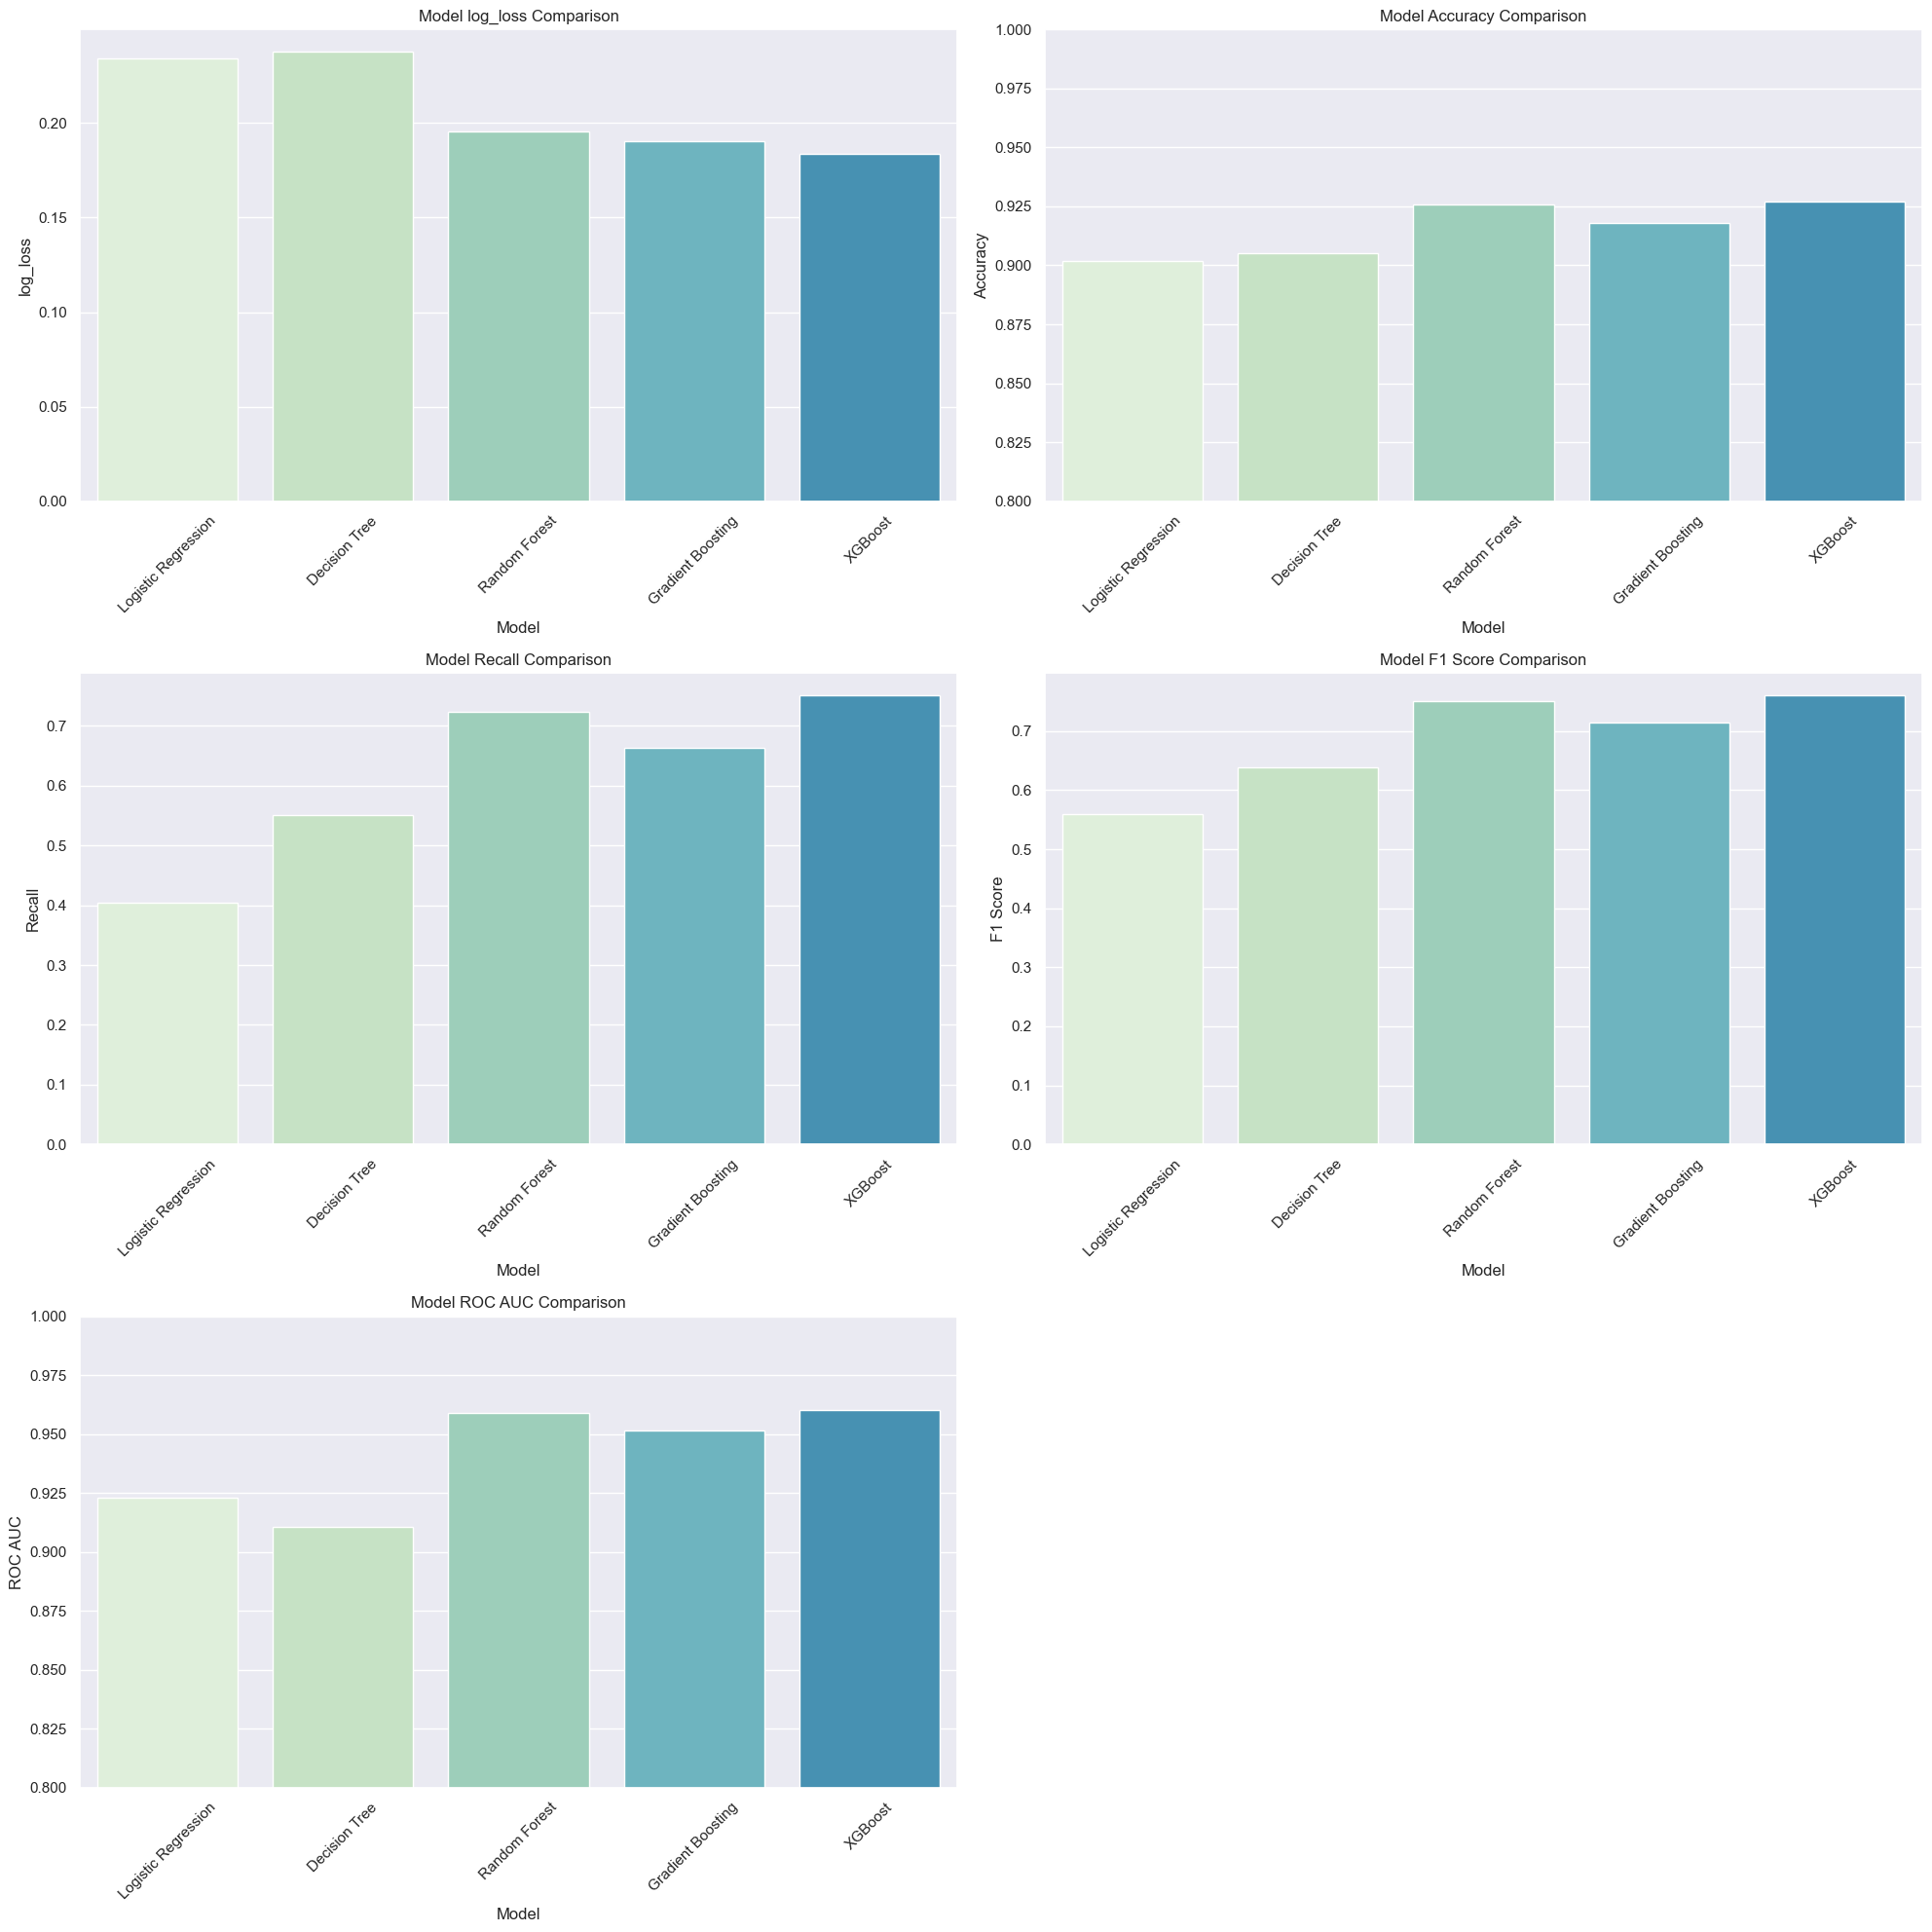

In [146]:

# 시각화
plt.figure(figsize=(20, 20))
sns.set_palette("GnBu")

# log_loss 막대 그래프
plt.subplot(3, 2, 1)
sns.barplot(data=results_data, x='Model', y='Log Loss')
plt.title('Model log_loss Comparison')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('log_loss')


# 정확도 막대 그래프
plt.subplot(3, 2, 2)
sns.barplot(data=results_data, x='Model', y='Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.8,1.0)


# 재현율 막대 그래프
plt.subplot(3, 2, 3)
sns.barplot(data=results_data, x='Model', y='Recall')
plt.title('Model Recall Comparison')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Recall')


# F1 점수 막대 그래프
plt.subplot(3, 2, 4)
sns.barplot(data=results_data, x='Model', y='F1 Score')
plt.title('Model F1 Score Comparison')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('F1 Score')


# ROC AUC 막대 그래프
plt.subplot(3, 2, 5)
sns.barplot(data=results_data, x='Model', y='ROC AUC')
plt.title('Model ROC AUC Comparison')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.ylim(0.8,1.)

plt.tight_layout()
plt.show()


pd.melt: results_data 데이터프레임을 긴 형식으로 변환합니다. 각 행이 하나의 평가 지표를 나타내도록 변경합니다

In [147]:
# 데이터 변환 (긴 형식으로 변환)
melted_data = pd.melt(results_data, id_vars=['Model'], value_vars=[ 'Log Loss', 'Recall', 'F1 Score','Accuracy', 'ROC AUC'],
                      var_name='Metric', value_name='Score')
# 여기서 x 좌표의 순서를 바꿔줄 수 있어용

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


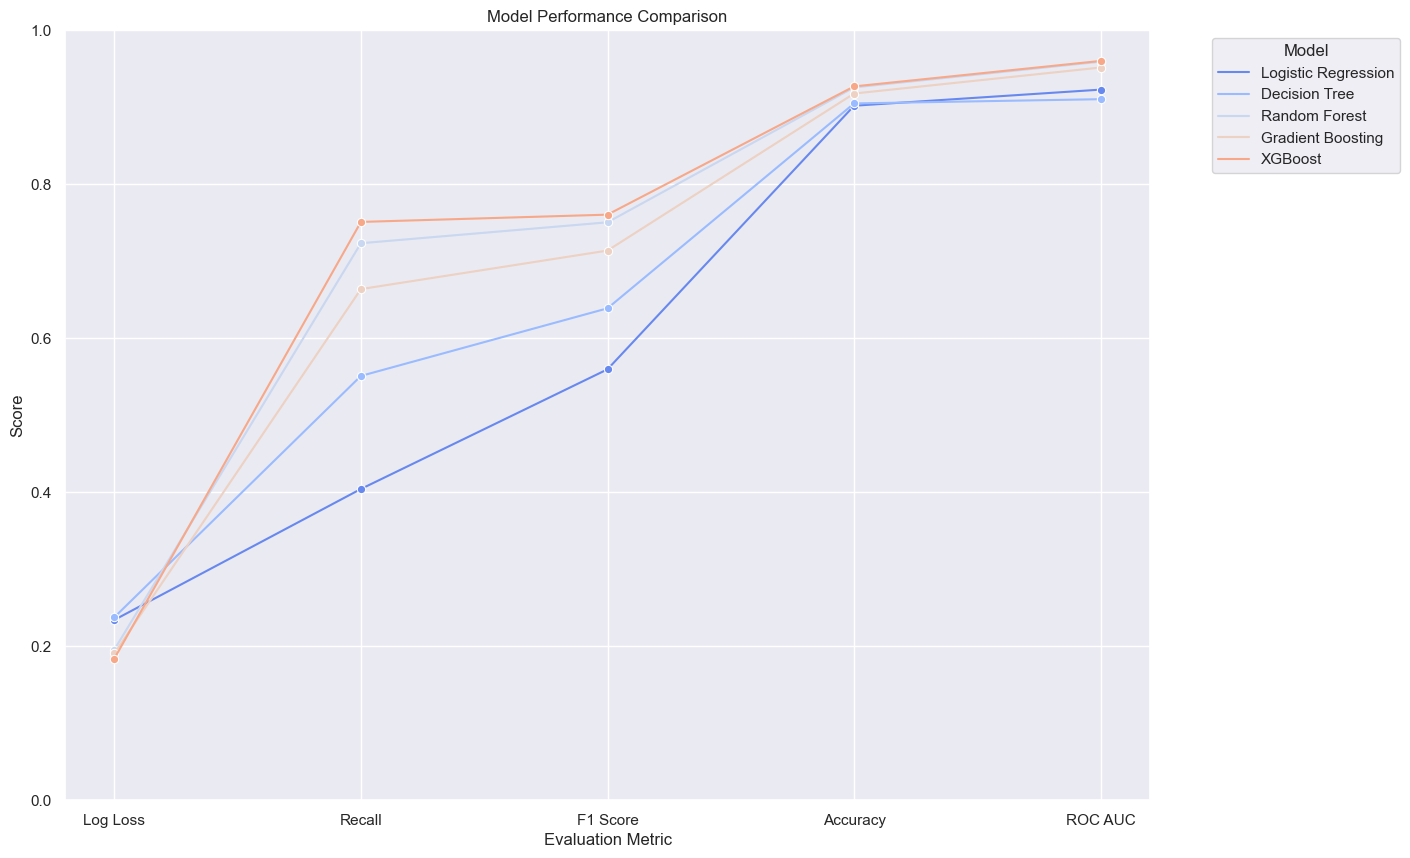

In [148]:

# 시각화
plt.figure(figsize=(14, 10))
sns.set_palette("coolwarm")# 여기서  팔렛트를 바꾸면 됩니당
sns.lineplot(data=melted_data, x='Metric', y='Score', hue='Model', marker='o')

plt.title('Model Performance Comparison')
plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # 필요에 따라 y축 범위 조정
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


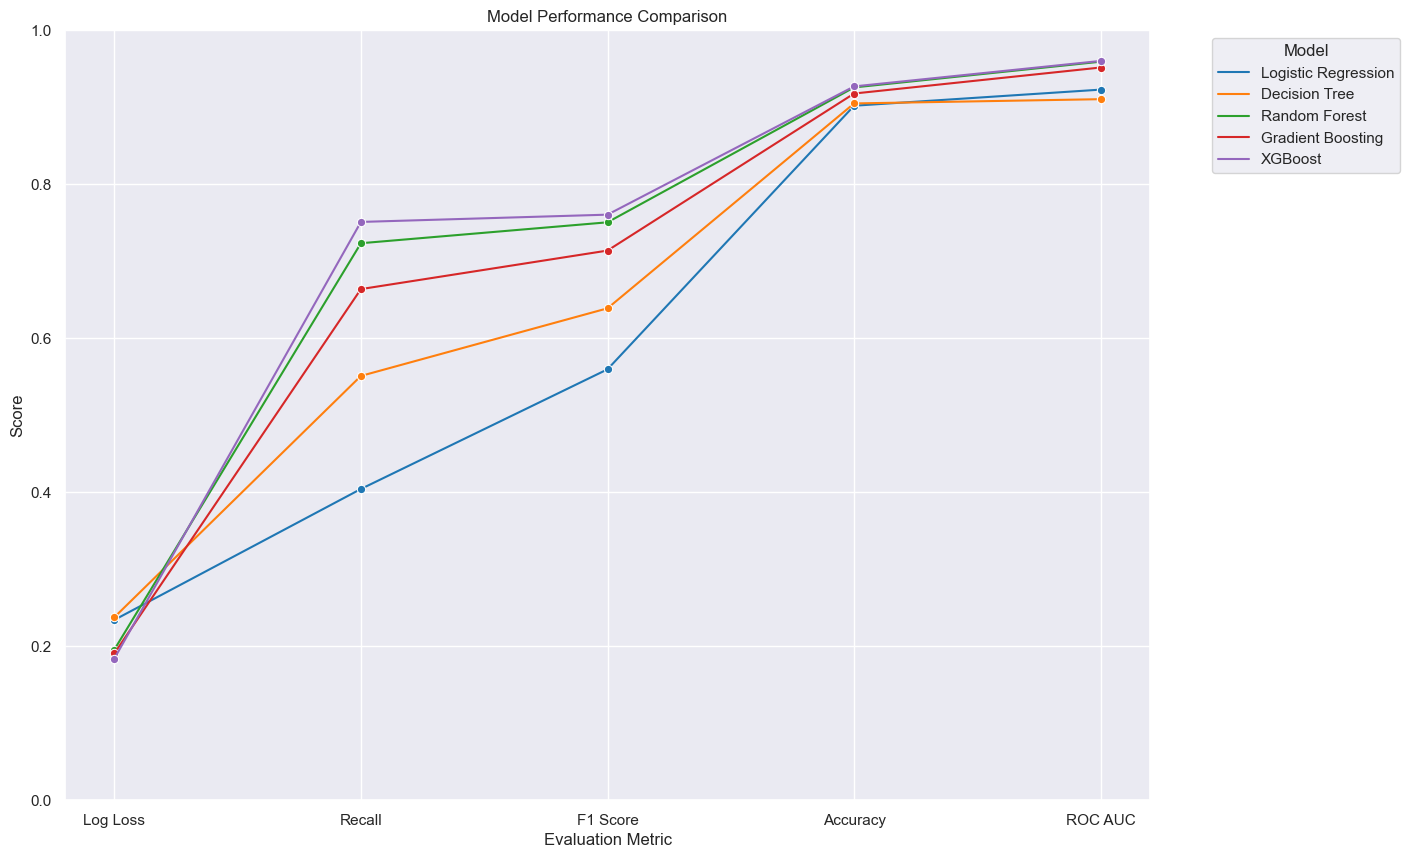

In [149]:


# 시각화
plt.figure(figsize=(14, 10))
sns.set_palette("tab10")# 여기서  팔렛트를 바꾸면 됩니당
sns.lineplot(data=melted_data, x='Metric', y='Score', hue='Model', marker='o')

plt.title('Model Performance Comparison')
plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # 필요에 따라 y축 범위 조정
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


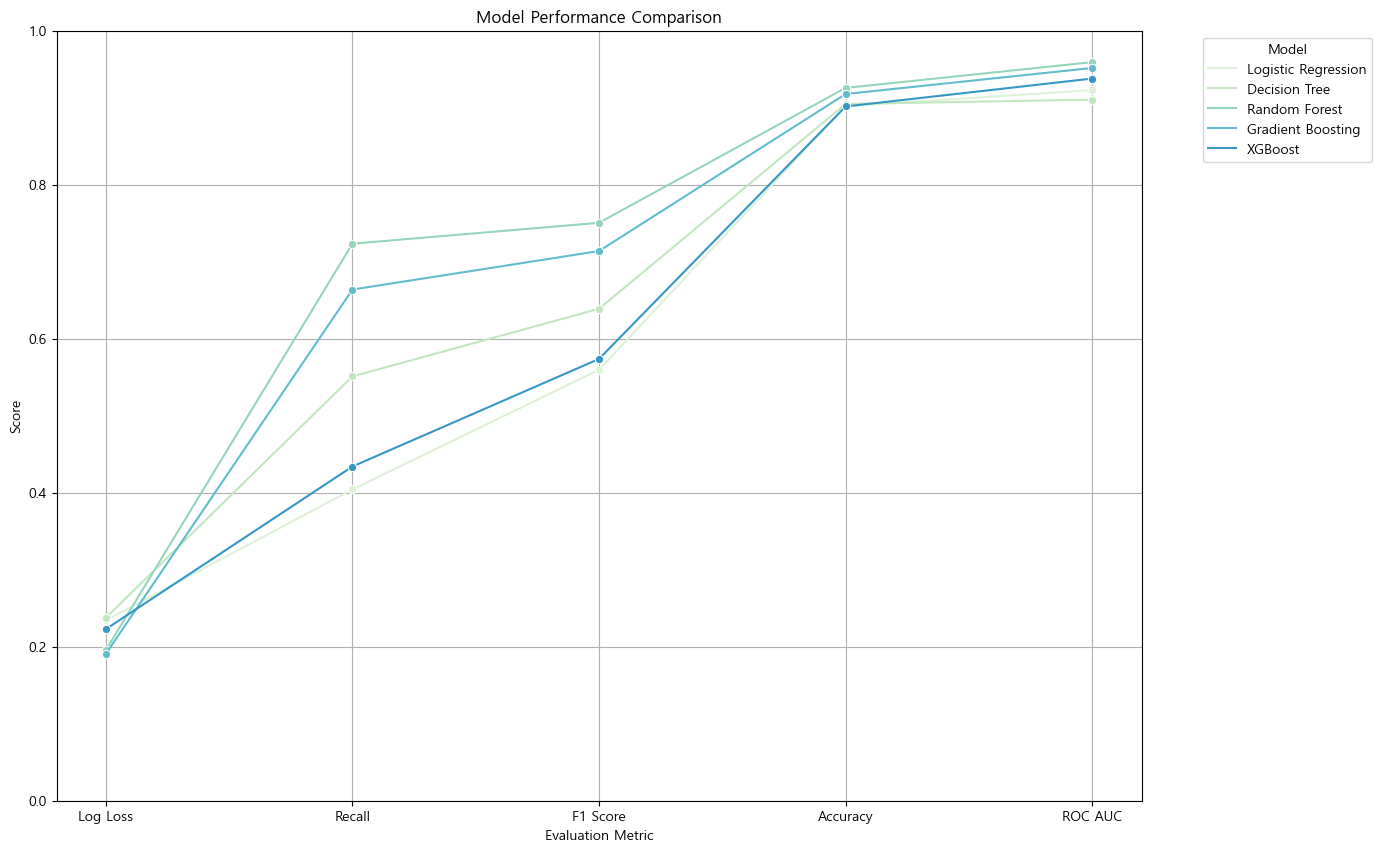

In [20]:

plt.figure(figsize=(14, 10))
sns.set_palette("GnBu")# 여기서  팔렛트를 바꾸면 됩니당
sns.lineplot(data=melted_data, x='Metric', y='Score', hue='Model', marker='o')

plt.title('Model Performance Comparison')
plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # 필요에 따라 y축 범위 조정
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


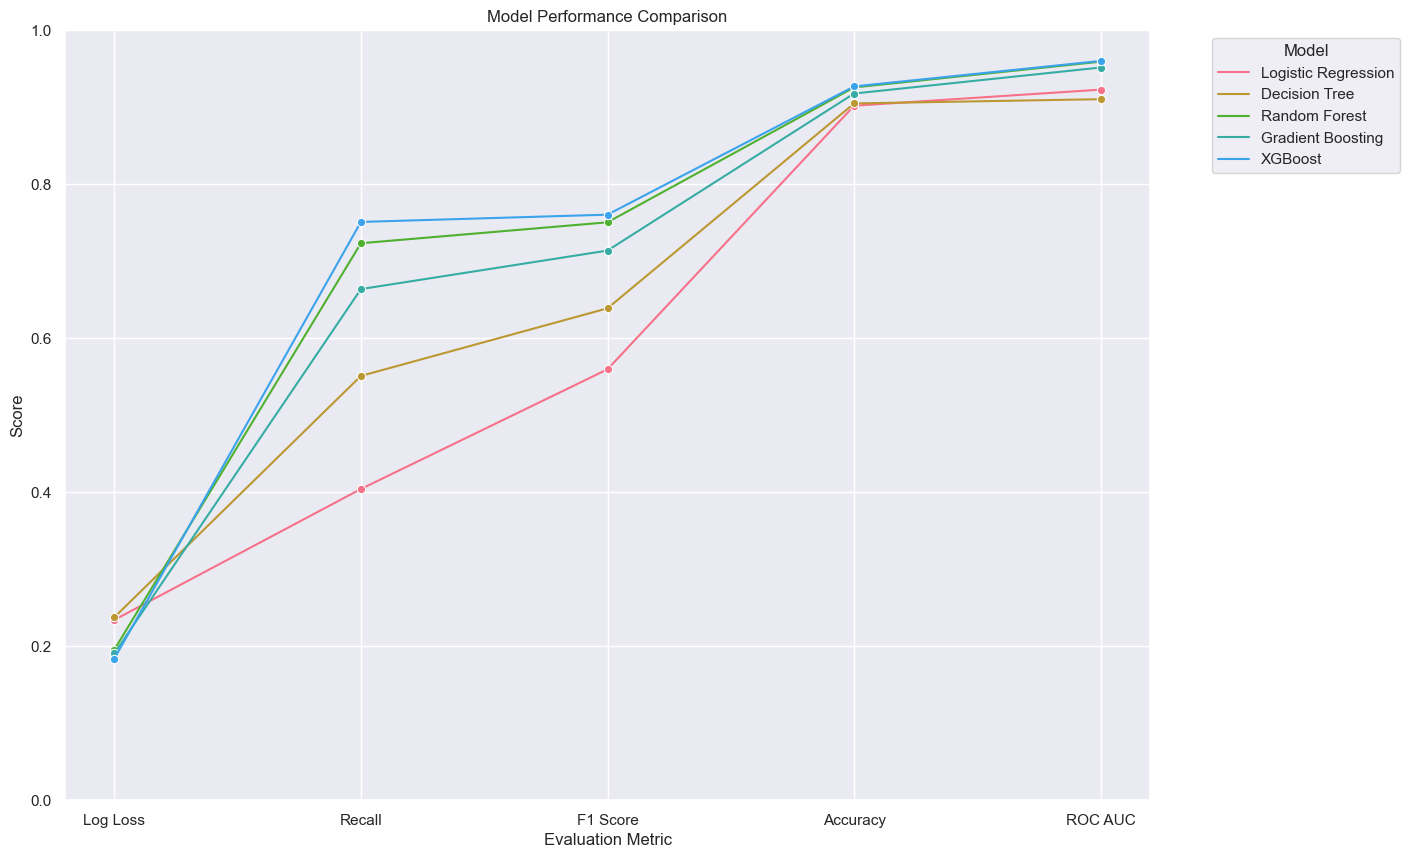

In [150]:

plt.figure(figsize=(14, 10))
sns.set_palette("husl") # 여기서  팔렛트를 바꾸면 됩니당 이거는 gpt 추천이라 그냥 한번 써봤어용
sns.lineplot(data=melted_data, x='Metric', y='Score', hue='Model', marker='o')

plt.title('Model Performance Comparison')
plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # 필요에 따라 y축 범위 조정
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

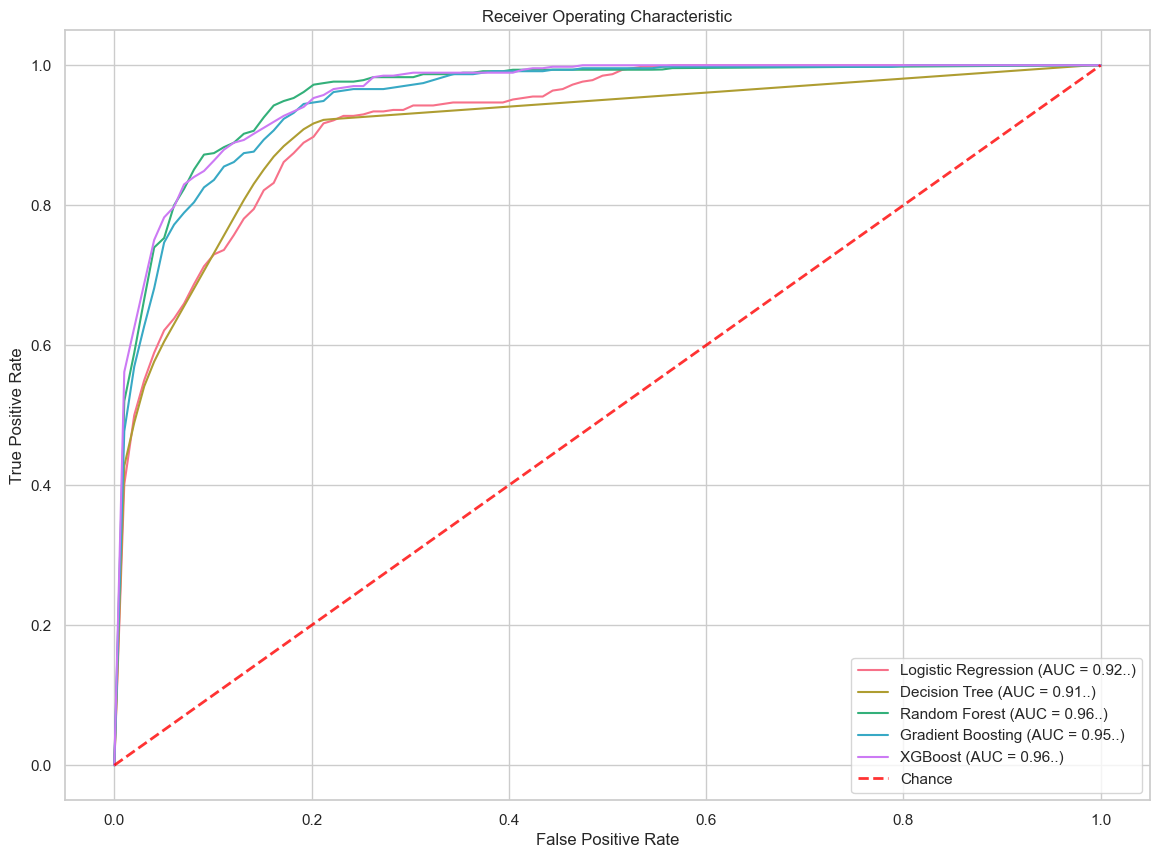

In [151]:

# Seaborn 스타일 설정 위에처럼 다 그리면 코드가 너무 길어질거 같아서 주석처리 된친구들 하나씩 바꿔주면서 진행 해도 됩니당.
# 간단히 for문을 돌릴까 했는데 실행되는데 오래걸려서 이게 나은거 같아요잉..
 
sns.set(style="whitegrid", palette="husl")
palette = sns.color_palette("husl", 5) 
# 여기서 팔렛트를 바꿔줍니당 우리는 색 5개가 필요해서 ,5 로 다섯개만 골라서 배열을 만든 것입니다.

# sns.set(style="whitegrid", palette="tab10")
# palette = sns.color_palette("tab10", 5)

# sns.set(style="whitegrid", palette="coolwarm")
# palette = sns.color_palette("coolwarm", 5)

# sns.set(style="whitegrid", palette="GnBu")
# palette = sns.color_palette("GnBu", 5)



# 교차 검증 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

# ROC 곡선을 그리기 위한 설정
plt.figure(figsize=(14, 10))

for i, (model_name, model) in enumerate(models):
    # 교차 검증을 통한 ROC 곡선 데이터 수집
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train, test in skf.split(X, y):
        model.fit(X.iloc[train], y.iloc[train])
        probas_ = model.predict_proba(X.iloc[test])
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    plt.plot(mean_fpr, mean_tpr, color=palette[i], label=f'{model_name} (AUC = {mean_auc:.2f}..)')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# 최적의 모델

### XGBoost

XGBoost1의 하이퍼 파라미터를 고르는 시각화

Best hyperparameters: 
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 100}
XGBoost Accuracy: 0.935093509350935

Best hyperparameters: 
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 100}
XGBoost Accuracy: 0.935093509350935

선 (Line):  

각 하이퍼 파라미터 값에 따른 모델의 평균 성능을 나타냅니다. 예를 들어, n_estimators가 10, 20, 30 등일 때 모델의 평균 교차 검증 점수를 연결하여 보여줍니다.  

범위 (Shade or Band):  

범위는 평균 점수의 신뢰 구간을 나타냅니다. 기본적으로 seaborn은 95% 신뢰 구간을 표시합니다.  
신뢰 구간은 평균 점수의 불확실성을 반영합니다. 즉, 여러 번의 교차 검증 결과의 변동성을 시각적으로 나타냅니다.  


### 좀더 정확한 파라미터 비교용 코드입니다 (neg_log_loss)

In [17]:

# 하이퍼 파라미터 설정
learning_rate_range = np.linspace(0.01, 0.2, 20)
colsample_bytree_range = np.linspace(0.3, 1.0, 8)
n_estimators_range = range(50, 401, 50)
gamma_range = np.linspace(0, 0.5, 6)
max_depth_range = range(1, 21)
min_child_weight_range = range(1, 21)


# # StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
# 결과 저장용 리스트
results_list_lr = []
results_list_colsample = []
results_list_n_estimators = []
results_list_gamma = []
results_list_max_depth = []
results_list_min_child_weight = []

# learning_rate 성능 평가
for lr in learning_rate_range:
    model = xgb.XGBClassifier(learning_rate=lr, random_state=4, use_label_encoder=False, eval_metric='logloss')
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='neg_log_loss')
    results_list_lr.append(pd.DataFrame({
        'Hyperparameter': ['learning_rate'] * len(scores),
        'Value': [lr] * len(scores),
        'Score': scores
    }))

# colsample_bytree 성능 평가
for colsample in colsample_bytree_range:
    model = xgb.XGBClassifier(colsample_bytree=colsample, random_state=4, use_label_encoder=False, eval_metric='logloss')
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='neg_log_loss')
    results_list_colsample.append(pd.DataFrame({
        'Hyperparameter': ['colsample_bytree'] * len(scores),
        'Value': [colsample] * len(scores),
        'Score': scores
    }))

# n_estimators 성능 평가
for n in n_estimators_range:
    model = xgb.XGBClassifier(n_estimators=n, random_state=4, use_label_encoder=False, eval_metric='logloss')
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='neg_log_loss')
    results_list_n_estimators.append(pd.DataFrame({
        'Hyperparameter': ['n_estimators'] * len(scores),
        'Value': [n] * len(scores),
        'Score': scores
    }))

# gamma 성능 평가
for gamma in gamma_range:
    model = xgb.XGBClassifier(gamma=gamma, random_state=4, use_label_encoder=False, eval_metric='logloss')
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='neg_log_loss')
    results_list_gamma.append(pd.DataFrame({
        'Hyperparameter': ['gamma'] * len(scores),
        'Value': [gamma] * len(scores),
        'Score': scores
    }))

# max_depth 성능 평가
for depth in max_depth_range:
    model = xgb.XGBClassifier(max_depth=depth, random_state=4, use_label_encoder=False, eval_metric='logloss')
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='neg_log_loss')
    results_list_max_depth.append(pd.DataFrame({
        'Hyperparameter': ['max_depth'] * len(scores),
        'Value': [depth] * len(scores),
        'Score': scores
    }))

# min_child_weight 성능 평가
for weight in min_child_weight_range:
    model = xgb.XGBClassifier(min_child_weight=weight, random_state=4, use_label_encoder=False, eval_metric='logloss')
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='neg_log_loss')
    results_list_min_child_weight.append(pd.DataFrame({
        'Hyperparameter': ['min_child_weight'] * len(scores),
        'Value': [weight] * len(scores),
        'Score': scores
    }))

# 결과 합치기
results_lr = pd.concat(results_list_lr, ignore_index=True)
results_colsample = pd.concat(results_list_colsample, ignore_index=True)
results_n_estimators = pd.concat(results_list_n_estimators, ignore_index=True)
results_gamma = pd.concat(results_list_gamma, ignore_index=True)
results_max_depth = pd.concat(results_list_max_depth, ignore_index=True)
results_min_child_weight = pd.concat(results_list_min_child_weight, ignore_index=True)


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


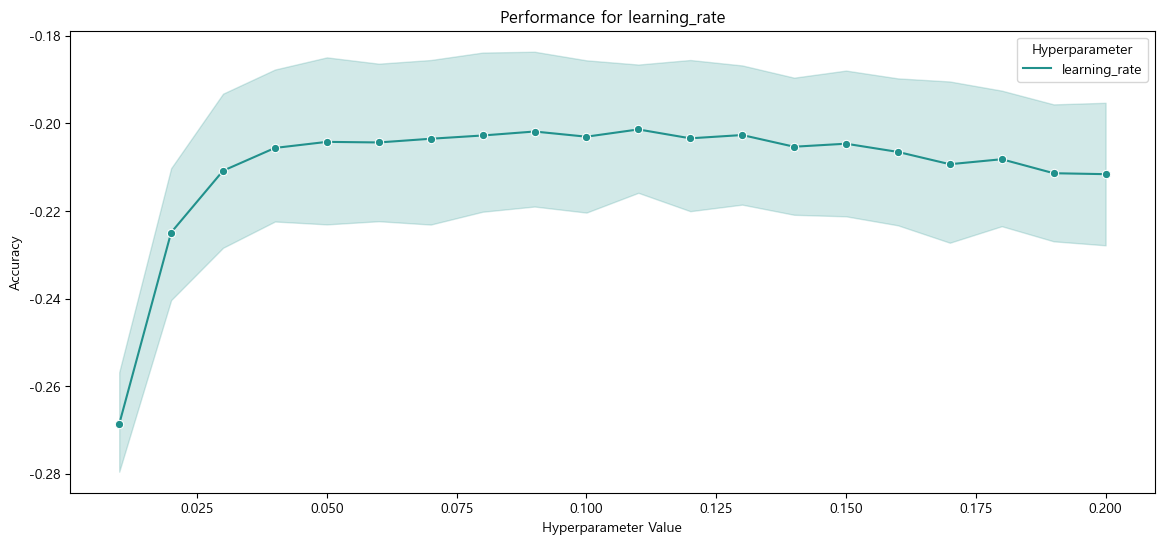

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


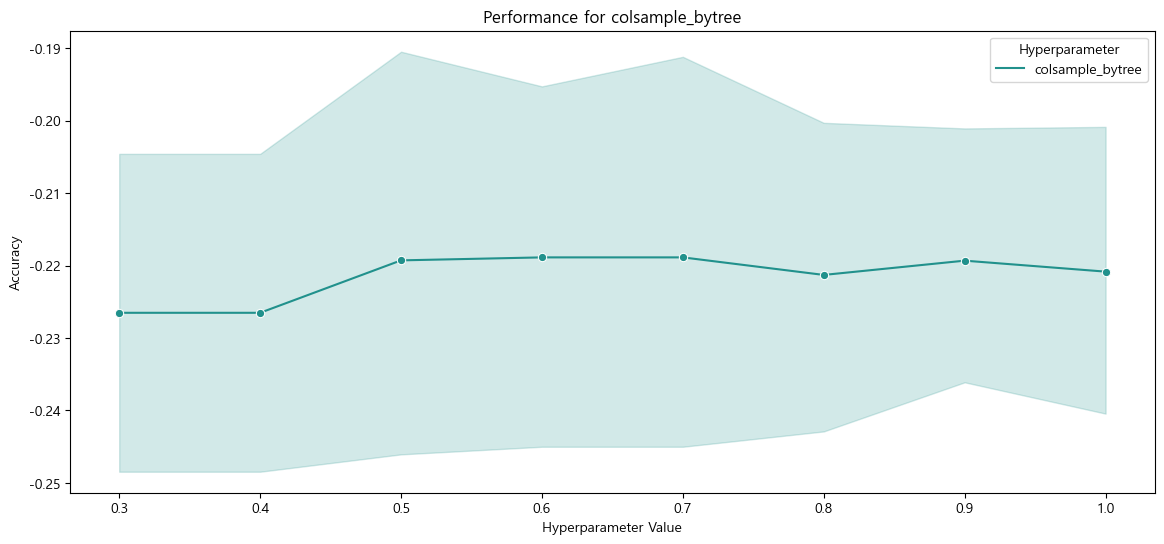

In [18]:
# learning_rate와 colsample_bytree 그래프
plt.figure(figsize=(14, 6))
sns.lineplot(data=results_lr, x='Value', y='Score', hue='Hyperparameter', marker='o', palette='viridis')
plt.title('Performance for learning_rate')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Accuracy')
plt.legend(title='Hyperparameter')
plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(data=results_colsample, x='Value', y='Score', hue='Hyperparameter', marker='o', palette='viridis')
plt.title('Performance for colsample_bytree')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Accuracy')
plt.legend(title='Hyperparameter')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


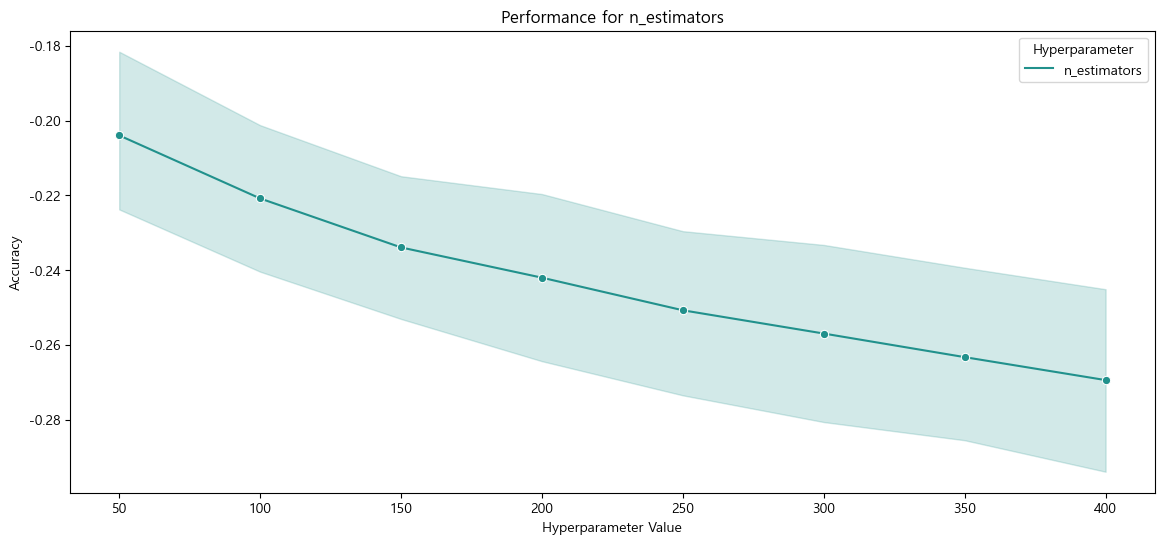

In [19]:

# n_estimators 그래프
plt.figure(figsize=(14, 6))
sns.lineplot(data=results_n_estimators, x='Value', y='Score', hue='Hyperparameter', marker='o', palette='viridis')
plt.title('Performance for n_estimators')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Accuracy')
plt.legend(title='Hyperparameter')
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


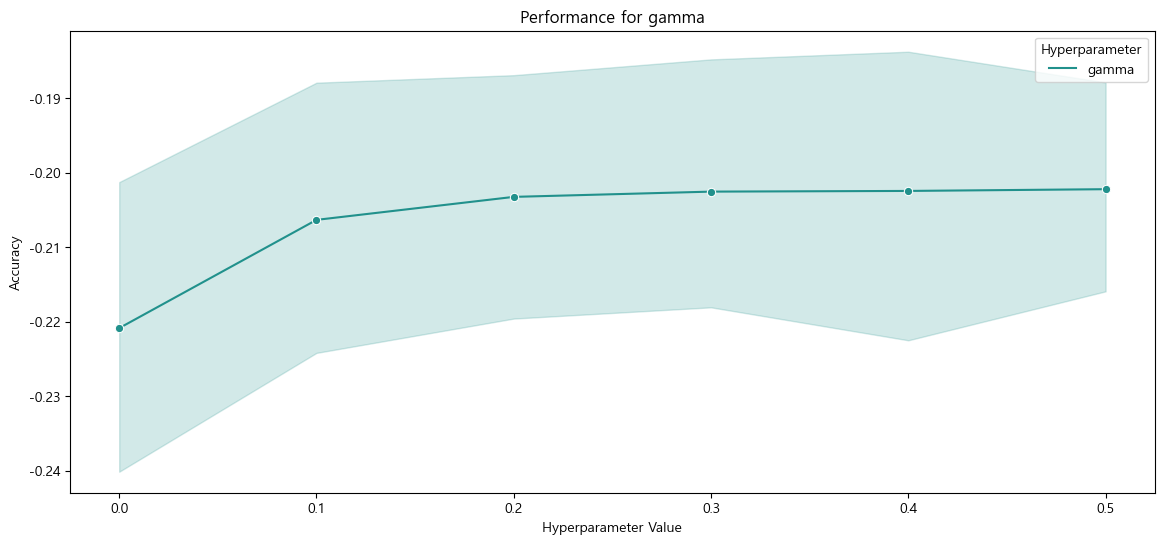

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


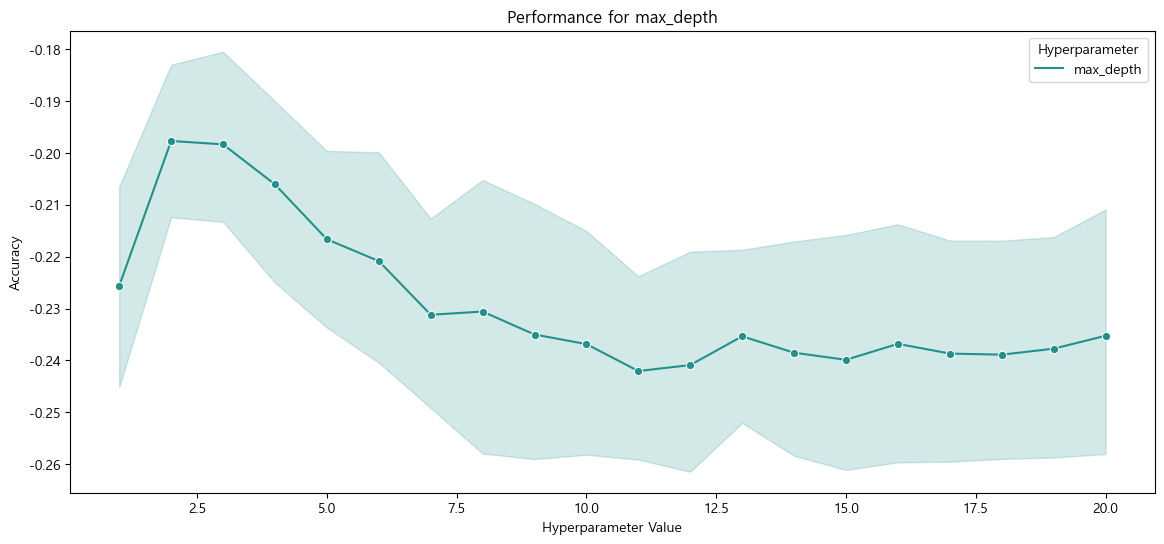

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


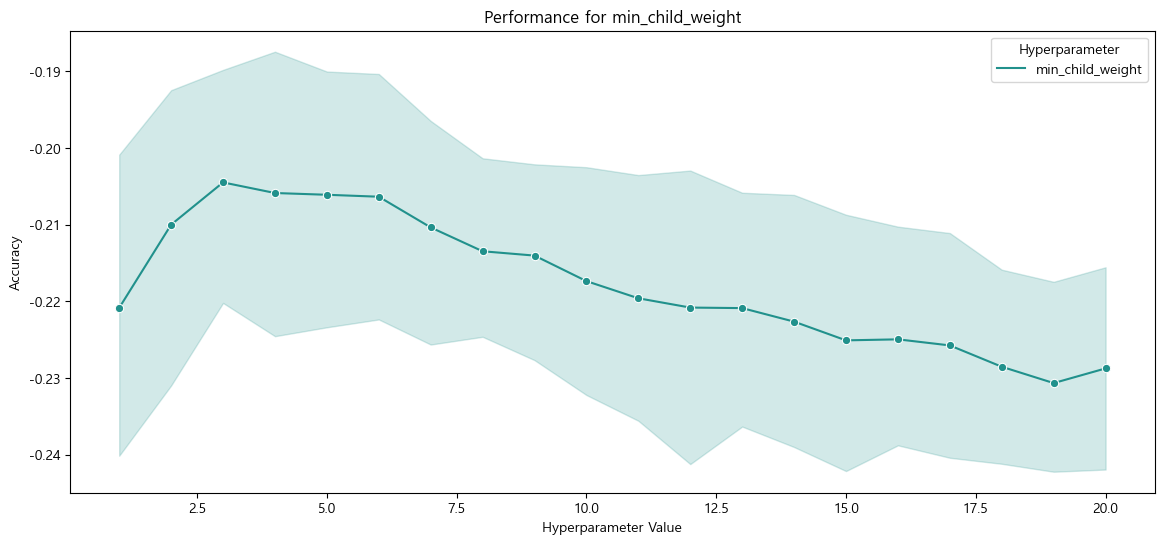

In [20]:
# gamma, max_depth, min_child_weight 그래프
plt.figure(figsize=(14, 6))
sns.lineplot(data=results_gamma, x='Value', y='Score', hue='Hyperparameter', marker='o', palette='viridis')
plt.title('Performance for gamma')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Accuracy')
plt.legend(title='Hyperparameter')
plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(data=results_max_depth, x='Value', y='Score', hue='Hyperparameter', marker='o', palette='viridis')
plt.title('Performance for max_depth')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Accuracy')
plt.legend(title='Hyperparameter')
plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(data=results_min_child_weight, x='Value', y='Score', hue='Hyperparameter', marker='o', palette='viridis')
plt.title('Performance for min_child_weight')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Accuracy')
plt.legend(title='Hyperparameter')
plt.show()

                   Feature  Importance
4                   Status    0.508136
0                Complains    0.372771
6              Usage Index    0.037679
1            Charge Amount    0.031590
2  Distinct Called Numbers    0.027579
5           Customer Value    0.022244
3              Tariff Plan    0.000000


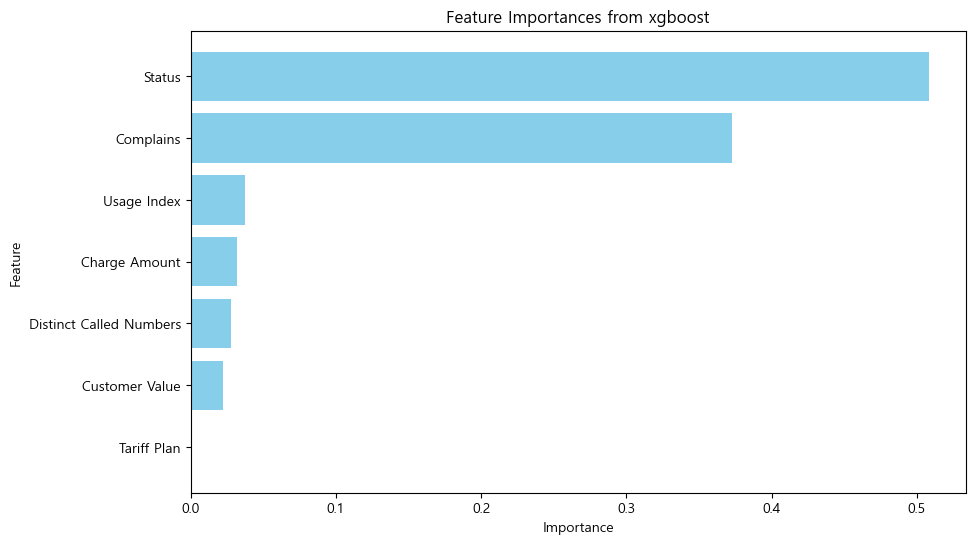

In [9]:
# 변수 중요도 추출
importances = best_xgb_classifier.feature_importances_

# 변수 중요도를 데이터프레임으로 변환
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from xgboost')
plt.gca().invert_yaxis()  # 중요도가 높은 변수를 위쪽에 배치
plt.show()

                   Feature  Importance
0                Complains    0.595983
4                   Status    0.255893
6              Usage Index    0.109812
2  Distinct Called Numbers    0.038312
1            Charge Amount    0.000000
3              Tariff Plan    0.000000
5           Customer Value    0.000000


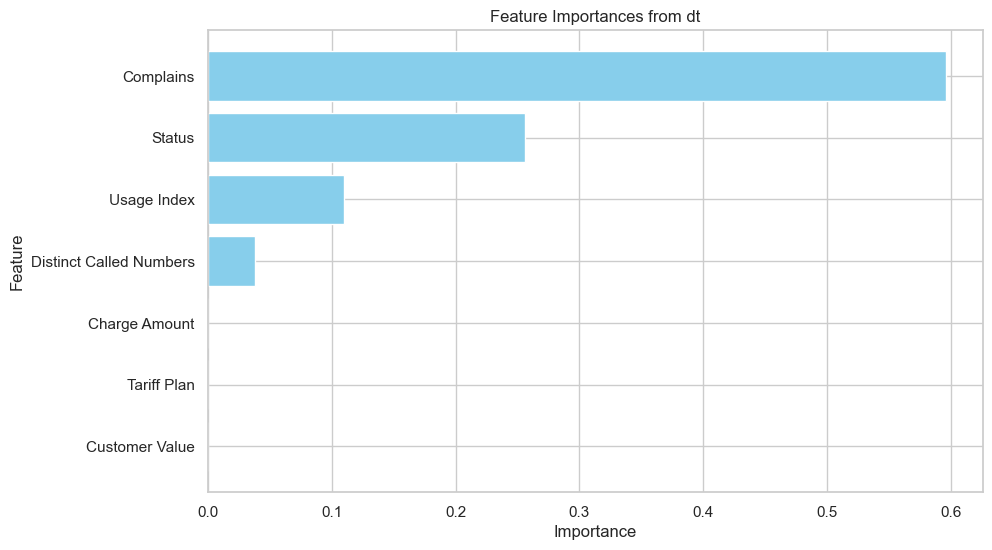

In [174]:
# 변수 중요도 추출
importances = best_dt_classifier.feature_importances_

# 변수 중요도를 데이터프레임으로 변환
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from dt')
plt.gca().invert_yaxis()  # 중요도가 높은 변수를 위쪽에 배치
plt.show()

                   Feature  Importance
0                Complains    0.262092
6              Usage Index    0.227748
5           Customer Value    0.205457
4                   Status    0.151149
2  Distinct Called Numbers    0.127081
1            Charge Amount    0.024303
3              Tariff Plan    0.002169


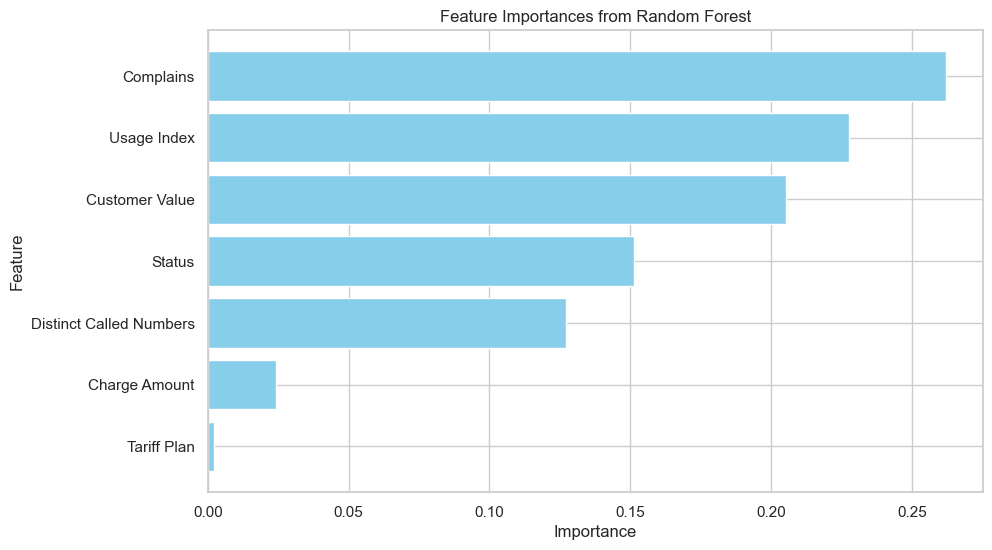

In [175]:
# 변수 중요도 추출
importances = best_rf_classifier.feature_importances_

# 변수 중요도를 데이터프레임으로 변환
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # 중요도가 높은 변수를 위쪽에 배치
plt.show()

학습되지 않은 test셋에서 사람을 랜덤으로 10명을 뽑아서 결과를 맞춰 보는 프로그램을 해봅시다.

In [176]:
np.random.seed(4)
test_indices_final = np.random.choice(X_test.shape[0], 10, replace=False)

X_test_sample_final = X_test.iloc[test_indices_final]
y_test_sample_final = y_test.iloc[test_indices_final]

y_pred_sample_final = best_xgb_classifier.predict(X_test_sample_final)


# 선택된 샘플의 인덱스와 예측 결과를 데이터프레임으로 저장하여 출력합니다.
result__final_df = pd.DataFrame({
    'Index': test_indices_final,
    'Actual': y_test_sample_final,
    'Predicted': y_pred_sample_final,
    'Isright' : y_test_sample_final == y_pred_sample_final
})
accuracy_final = result__final_df[result__final_df['Isright']==True].count()['Index']/10

print(result__final_df)

print(f"모델의 성능 : {accuracy_rf :.2f} 10명의 예측시 성능 : {accuracy_final :.2f}")


      Index  Actual  Predicted  Isright
2435    289       0          0     True
1166    239       0          0     True
342     815       0          0     True
301      76       0          0     True
2904     92       0          0     True
317     758       1          1     True
1769    423       1          1     True
154     770       0          0     True
2571    539       1          1     True
2927    155       0          0     True
모델의 성능 : 0.94 10명의 예측시 성능 : 1.00


In [179]:
np.random.seed(4)
test_indices_final = np.random.choice(X_test.shape[0], 1, replace=False)

X_test_sample_final = X_test.iloc[test_indices_final]
y_test_sample_final = y_test.iloc[test_indices_final]

y_pred_sample_final = best_xgb_classifier.predict(X_test_sample_final)


# 선택된 샘플의 인덱스와 예측 결과를 데이터프레임으로 저장하여 출력합니다.
result__final_df = pd.DataFrame({
    'Index': test_indices_final,
    'Actual': y_test_sample_final,
    'Predicted': y_pred_sample_final,
    'Isright' : y_test_sample_final == y_pred_sample_final
})
accuracy_final = result__final_df[result__final_df['Isright']==True].count()['Index']/1

print(result__final_df)

print(f"모델의 성능 : {accuracy_rf :.2f} 1명의 예측시 성능 : {accuracy_final :.2f}")


      Index  Actual  Predicted  Isright
2435    289       0          0     True
모델의 성능 : 0.94 1명의 예측시 성능 : 1.00


In [13]:
X.iloc[289]

Complains                     0.000000
Charge Amount                 2.000000
Distinct Called Numbers      16.000000
Tariff Plan                   1.000000
Status                        1.000000
Customer Value             1108.000000
Usage Index                   1.001354
Name: 289, dtype: float64